In [130]:
#import sys
#!conda install --yes --prefix {sys.prefix} statsmodels

Solving environment: done

## Package Plan ##

  environment location: /Users/jacobchambers/tensorflow-test/env

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.2                |   py38hca03da5_1         270 KB
    statsmodels-0.13.2         |   py38h1a28f6b_0         8.4 MB
    ------------------------------------------------------------
                                           Total:         8.6 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/osx-arm64::patsy-0.5.2-py38hca03da5_1
  statsmodels        pkgs/main/osx-arm64::statsmodels-0.13.2-py38h1a28f6b_0



patsy-0.5.2          | 270 KB    | ##################################### | 100% 
statsmodels-0.13.2   | 8.4 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [136]:
### importing libraries ###

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

In [137]:
### importing data ###

# features
features_train = pd.read_csv('features_train.csv', index_col = 0)
features_test = pd.read_csv('features_test.csv', index_col = 0)

# target
target_train = pd.read_csv('target_train.csv', index_col = 0)
target_test = pd.read_csv('target_test.csv', index_col = 0)

In [ ]:
# Let's first check to see how a linear regression model performs without any tuning.

In [138]:
### linear regression function ###

def run_model():
    
    model = LinearRegression().fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print('For the train set the r2 is:', r2_score(target_train, pred_train), 
          'and the RMSE is:', mean_squared_error(target_train, pred_train, squared = False))

    print('For the test set the r2 is:', r2_score(target_test, pred_test), 
          'and the RMSE is:', mean_squared_error(target_test, pred_test, squared = False))
    

run_model()

For the train set the r2 is: 0.03611919838796995 and the RMSE is: 0.9854976751299134
For the test set the r2 is: -0.04660620219887024 and the RMSE is: 1.0230377325391622


In [ ]:
# The r2 and RMSE values are quite poor for the base dataset. Let's see if we can improve this somehow. First let's # look at correlations.

/var/folders/t4/r4bqllr94wxbl5z813cfhn880000gn/T/ipykernel_10023/1417346758.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat, dtype = np.bool)


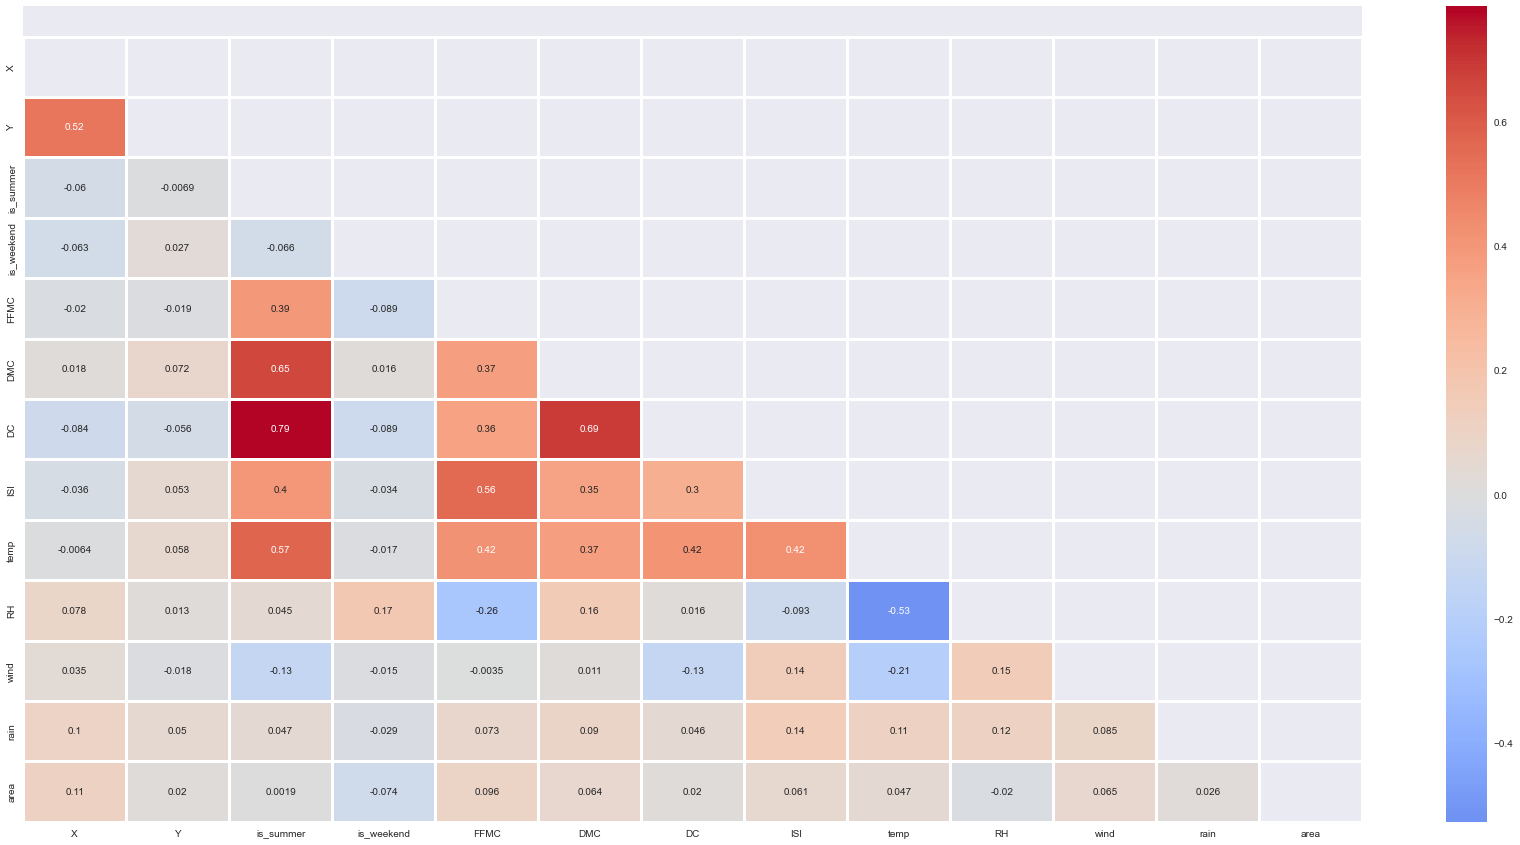

In [139]:
### checking correlations ###

# correlation matrix function
def create_corr():
    
    # creating correlation matrix
    train_joined = features_train.join(target_train)
    corr_mat = train_joined.corr()

    # mask
    mask = np.zeros_like(corr_mat, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plotting heat map
    plt.figure(figsize=(30, 15))
    sns.heatmap(corr_mat,cmap='coolwarm', center=0,annot=True, linewidths= 3, mask=mask)
    plt.ylim(len(train_joined.columns),-0.5, -0.5)
    plt.show()

create_corr()

In [ ]:
# We see that area does not have a strong correlation with any variable. We do see potential multicollinearity 
# however with X and Y, DC and both DMC and is_summer, etc. We will deal with multicollinearity later but for now, 
# let's see if we can improve correlations with area. First, we will visualize the relationships between the 
# features and target to see if there is a nonlinear relationship.

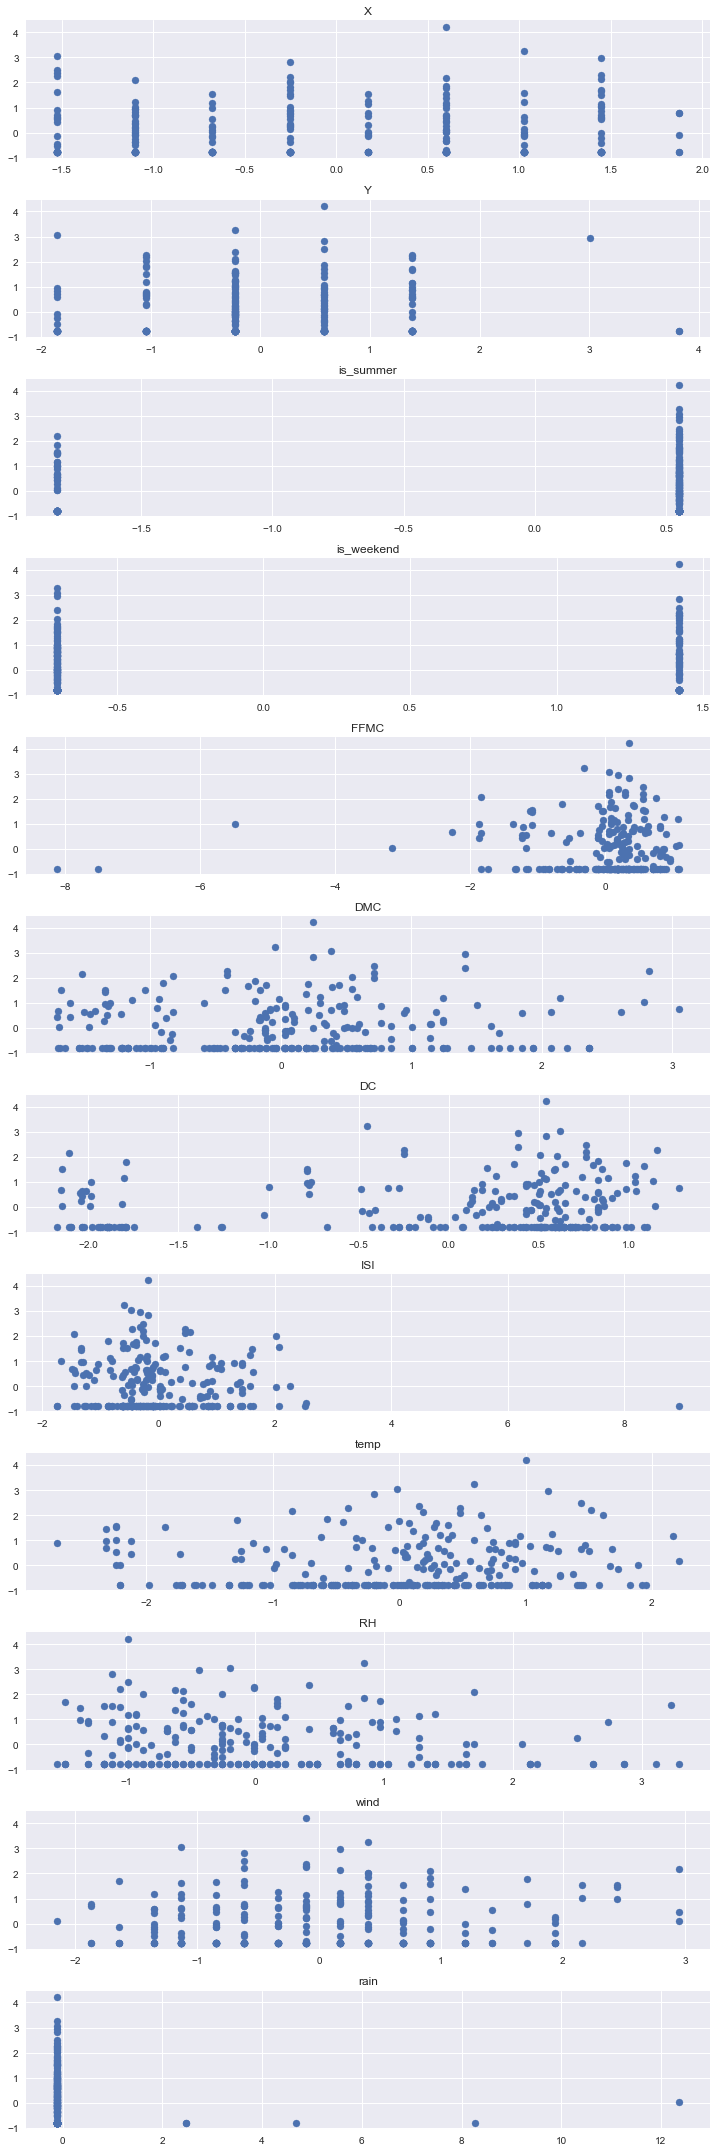

In [140]:
### scatterplots ###

# subplots
fig, ax = plt.subplots(12, figsize = (10, 30))

# initial index
index = 0

# scatterplots
for column in features_test.columns:
    ax[index].scatter(x = features_test[column], y = target_test)
    ax[index].title.set_text(column)
    index += 1
    
plt.tight_layout()

/var/folders/t4/r4bqllr94wxbl5z813cfhn880000gn/T/ipykernel_10023/1417346758.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat, dtype = np.bool)


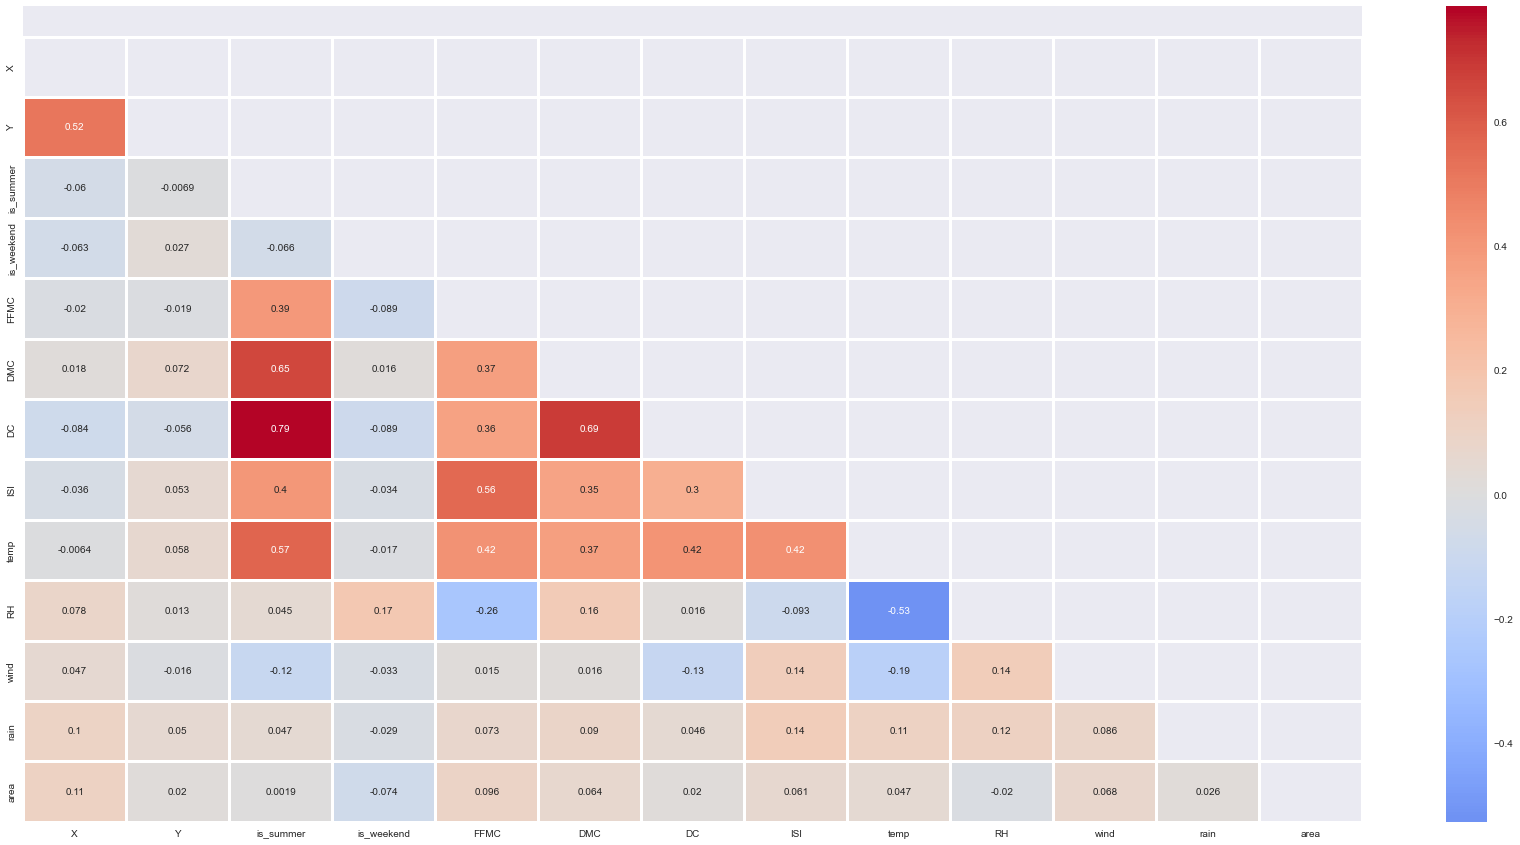

In [141]:
### accounting for quadratic relationship ###

features_train['wind'] = features_train['wind'].apply(lambda x: (x + 3) ** 0.5)
features_test['wind'] = features_test['wind'].apply(lambda x: (x + 3) ** 0.5)

create_corr()

In [ ]:
# We see that the correlation between wind and area went from 0.065 to 0.068 which is insignificant but better. 
# Let's check to see how the model does (even though the difference is so small that it shouldn't make a noticeable # difference).

In [142]:
run_model()

For the train set the r2 is: 0.03600046323964423 and the RMSE is: 0.9855583722664808
For the test set the r2 is: -0.04697028521418001 and the RMSE is: 1.023215659191248


In [ ]:
# The model metrics are slightly worse but likely to be within error. Let's now account for multicollinearity by 
# checking variational influence factors.

In [143]:
# variation inflation factor

# function for VIF
def check_vif():
    vif = pd.Series([variance_inflation_factor(features_train.values, i) 
                   for i in range(features_train.shape[1])], 
                  index = features_train.columns)
    print(vif)

check_vif()

X             1.436186
Y             1.409198
is_summer     4.232285
is_weekend    1.113314
FFMC          1.754038
DMC           2.385113
DC            3.252040
ISI           1.734717
temp          3.344481
RH            2.537820
wind          1.133332
rain          1.109356
dtype: float64


In [144]:
### dropping columns ###

# columns we will keep
model_columns = ['X', 'is_weekend', 'FFMC', 'DMC', 'ISI', 'wind']

# saving old data just incase
features_train_save = features_train.copy()
features_test_save = features_test.copy()

# revamping
features_train = features_train.loc[:, model_columns]
features_test = features_test.loc[: , model_columns]

In [145]:
### checking new model ###

run_model()

For the train set the r2 is: 0.028691049115701528 and the RMSE is: 0.9892877569511216
For the test set the r2 is: -0.02392974538299608 and the RMSE is: 1.0118941374387915


/var/folders/t4/r4bqllr94wxbl5z813cfhn880000gn/T/ipykernel_10023/1417346758.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat, dtype = np.bool)


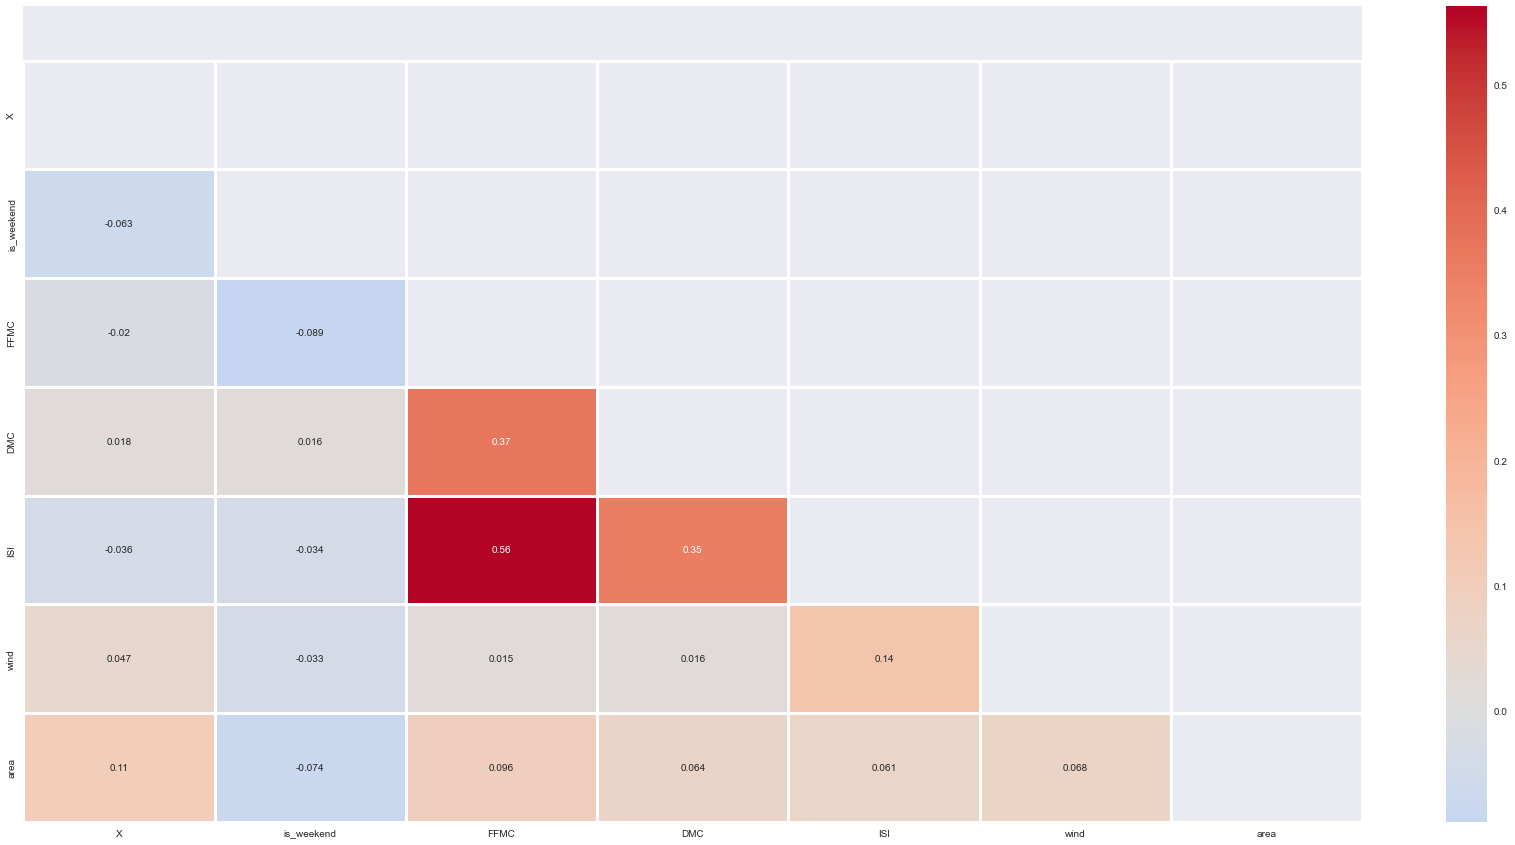

In [146]:
### checking correlations ###

create_corr()

In [147]:
### dropping columns ###

# columns we will keep
model_columns = ['X', 'is_weekend', 'FFMC']

# saving old data just incase
features_train_save = features_train.copy()
features_test_save = features_test.copy()

# revamping
features_train = features_train.loc[:, model_columns]
features_test = features_test.loc[: , model_columns]

In [148]:
### checking new model ###

run_model()

For the train set the r2 is: 0.024228292426541453 and the RMSE is: 0.9915578333035668
For the test set the r2 is: -0.03481926920040901 and the RMSE is: 1.0172606692487471


In [149]:
### using best model

# recovering features
features_train = features_train_save
features_test = features_test_save

# creating model
model = LinearRegression().fit(features_train, target_train)

#5 fold cross validation
cross_val = cross_val_score(model, features_test, target_test, cv = 5)

print('The cross val mean is:', np.mean(cross_val), 'and variance is:', np.std(cross_val))

The cross val mean is: -0.031763204349532434 and variance is: 0.07550871134919483
